**Download and import library in need**

In [ ]:
!nvidia-smi

Wed Aug  4 07:47:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 895 kB 15.5 MB/s 
     |████████████████████████████████| 1.2 MB 80.9 MB/s 
     |████████████████████████████████| 1.8 MB 76.8 MB/s 
     |████████████████████████████████| 138 kB 73.3 MB/s 
     |████████████████████████████████| 170 kB 74.6 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 133 kB 71.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 967 kB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=ca59addf0b92ef673cc1d1a2242af8eb289d1a05772790c4edaee5f3bedadc3a
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=34ac4cd9c684578b6d015bb4414b425de7ca675ac85f05fe814c092dd93f231f
  Sto

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 28924, done.
remote: Total 28924 (delta 0), reused 0 (delta 0), pack-reused 28924
Receiving objects: 100% (28924/28924), 12.12 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (21725/21725), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior bef

In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

**set seed**

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

**Download dataset**

In [ ]:
!apt-get install megatools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 148 kB of archives.
After this operation, 1,097 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 megatools amd64 1.9.98-1build2 [148 kB]
Fetched 148 kB in 1s (194 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../megatools_1.9.98-1build2_amd64.deb ...
Unpacking megatools (1.9.98-1build2) ...
Setting up megatools (1.9.98-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
#    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
#    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
  'ted2020.tgz', # train & dev
  'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
  path = prefix/f
  if not path.exists():
    if 'mega' in u:
      !megadl {u} --path {path}
    else:
      !wget {u} -O {path}
  if path.suffix == ".tgz":
    !tar -xvf {path} -C {prefix}
  elif path.suffix == ".zip":
    !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

Downloaded ted2020.tgz
raw.en
raw.zh
Downloaded test.tgz
test.en
test.zh


**set language**

In [ ]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix + '.' + src_lang} -n 5
!head {data_prefix + '.' + tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


**Preprocessing**

In [ ]:
import re

def strQ2B(ustring):
  #把字串全形轉半形
  ss = []
  for s in ustring:
    rstring = ""
    for uchar in s:
      inside_code = ord(uchar)
      if inside_code == 12288: #全形空格直接轉換
        inside_code = 32
      elif (inside_code >= 65281) and inside_code <= 65374:
        inside_code -= 65248
      rstring += chr(inside_code)
    ss.append(rstring)
  return ''.join(ss)

def clean_s(s, lang):
  if lang == 'en':
    s = re.sub(r"\([^()]*\)", "", s)
    s = s.replace('-', '')
    s = re.sub('([.,;~?()\"])', r' \1 ', s) 
  elif lang == 'zh':
    s = strQ2B(s)
    s = re.sub(r"\([^()]*\)", "", s)
    s = s.replace(' ', '')
    s = s.replace('—', '')
    s = s.replace('“', '"')
    s = s.replace('”', '"')
    s = s.replace('_', '')
    s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
  s = ' '.join(s.strip().split())
  return s

def len_s(s, lang):
  if lang == 'zh':
    return len(s)
  return len(s.split())

def clean_corpus(prefix, l1, l2, ratio = 9, max_len = 1000, min_len = 1):
  if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
    print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
    return
  with open(f'{prefix}.{l1}', 'r') as l1_in_f:
    with open(f'{prefix}.{l2}', 'r') as l2_in_f:
      with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
        with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
          for s1 in l1_in_f:
            s1 = s1.strip()
            s2 = l2_in_f.readline().strip()
            s1 = clean_s(s1, l1)
            s2 = clean_s(s2, l2)
            s1_len = len_s(s1, l1)
            s2_len = len_s(s2, l2)
            if min_len > 0: # remove short sentence
              if s1_len < min_len or s2_len < min_len:
                continue
            if max_len > 0: # remove long sentence
              if s1_len > max_len or s2_len > max_len:
                continue
            if ratio > 0: # remove by ratio of length
              if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                continue
            print(s1, file=l1_out_f)
            print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


**Split data into trainset and validationset**

In [ ]:
valid_ratio = 0.01
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
  print(f'train/valid splits exists. skipping split.')
else:
  line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
  labels = list(range(line_num))
  random.shuffle(labels)
  for lang in [src_lang, tgt_lang]:
    train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
    valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
    count = 0
    for line in open(f'{data_prefix}.clean.{lang}', 'r'):
      if labels[count]/line_num < train_ratio:
        train_f.write(line)
      else:
        valid_f.write(line)
        count += 1
    train_f.close()
    valid_f.close()

**Subword Units(斷詞單位,用於處理未登錄詞)**

In [ ]:
import sentencepiece as spm

vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
  print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
  spm.SentencePieceTrainer.train(
    input = ','.join([f'{prefix}/train.clean.{src_lang}', f'{prefix}/valid.clean.{src_lang}', f'{prefix}/train.clean.{tgt_lang}', f'{prefix}/valid.clean.{tgt_lang}']),
    model_prefix = prefix/f'spm{vocab_size}',
    vocab_size = vocab_size,
    character_coverage = 1,
    model_type = 'unigram',
    input_sentence_size = 1e6,
    shuffle_input_sentence = True,
    normalization_rule_name = 'nmt_nfkc_cf',
  )

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file = str(prefix/f'spm{vocab_size}.model'))
in_tag = {
  'train': 'train.clean',
  'valid': 'valid.clean',
  'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
  for lang in [src_lang, tgt_lang]:
    out_path = prefix/f'{split}.{lang}'
    if out_path.exists():
      print(f"{out_path} exists. skipping spm_encode.")
    else:
      with open(prefix/f'{split}.{lang}', 'w') as out_f:
        with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
          for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type = str)
            print(' '.join(tok), file = out_f)

In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


**Transfer fairseq to Binary(bug紀錄)**

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
  print(binpath, "exists, will not overwrite!")
else:
  !python -m fairseq_cli.preprocess \
    --source-lang {src_lang}\
    --target-lang {tgt_lang}\
    --trainpref {prefix/'train'}\
    --validpref {prefix/'valid'}\
    --testpref {prefix/'test'}\
    --destdir {binpath}\
    --joined-dictionary\
    --workers 2

2021-08-04 07:52:10 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

**Set some hyperparameter**

In [ ]:
config = Namespace(
  datadir = "./DATA/data-bin/ted2020",
  savedir = "./checkpoints/rnn",
  source_lang = "en",
  target_lang = "zh",
    
  # cpu threads when fetching & processing data.
  num_workers=2,  
  # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
  max_tokens=8192,
  accum_steps=2,
    
  # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
  lr_factor=2.,
  lr_warmup=4000,
    
  # clipping gradient norm helps alleviate gradient exploding
  clip_norm=1.0,
    
  # maximum epochs for training
  max_epoch=25,
  start_epoch=1,
    
  # beam size for beam search
  beam=5, 
  # generate sequences of maximum length ax + b, where x is the source length
  max_len_a=1.2, 
  max_len_b=10,
  # when decoding, post process sentence by removing sentencepiece symbols.
  post_process = "sentencepiece",
    
  # checkpoints
  keep_last_epochs=5,
  resume=None, # if resume from checkpoint name (under config.savedir)
    
  # logging
  use_wandb=False,
)

**Logging**

In [ ]:
logging.basicConfig(
  format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
  datefmt="%Y-%m-%d %H:%M:%S",
  level="INFO", # "DEBUG" "WARNING" "ERROR"
  stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
  import wandb
  wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

**Cuda environment**

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-08-04 09:09:17 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-08-04 09:09:17 | INFO | fairseq.utils | rank   0: capabilities =  6.0  ; total memory = 15.899 GB ; name = Tesla P100-PCIE-16GB                    
2021-08-04 09:09:17 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


**fairseq TranslationTask**

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
  data=config.datadir,
  source_lang=config.source_lang,
  target_lang=config.target_lang,
  train_subset="train",
  required_seq_len_multiple=8,
  dataset_impl="mmap",
  upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-08-04 09:09:18 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-08-04 09:09:18 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-08-04 09:09:20 | INFO | hw5.seq2seq | loading data for epoch 1
2021-08-04 09:09:20 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-08-04 09:09:20 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-08-04 09:09:20 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2021-08-04 09:09:20 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-08-04 09:09:20 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-08-04 09:09:20 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
  "Source: " + \
  task.source_dictionary.string(
    sample['source'],
    config.post_process,
  )
)
pprint.pprint(
  "Target: " + \
  task.target_dictionary.string(
    sample['target'],
    config.post_process,
  )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


**Dataset Iterator**

In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
  batch_iterator = task.get_batch_iterator(
    dataset=task.dataset(split),
    max_tokens=max_tokens,
    max_sentences=None,
    max_positions=utils.resolve_max_positions(
      task.max_positions(),
      max_tokens,
    ),
    ignore_invalid_inputs=True,
    seed=seed,
    num_workers=num_workers,
    epoch=epoch,
    disable_iterator_cache=not cached,
    # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
    # first call of this method has no effect. 
  )
  return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-08-04 09:09:23 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'net_input': {'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([19]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]])},
 'nsentences': 1,
 'ntokens': 18,
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

**define model**

In [ ]:
from fairseq.models import(
  FairseqEncoder,
  FairseqIncrementalDecoder,
  FairseqEncoderDecoderModel
)

**Encoder**

In [ ]:
class RNNEncoder(FairseqEncoder):
  def __init__(self, args, dictionary, embed_tokens):
    super().__init__(dictionary)
    self.embed_tokens = embed_tokens
        
    self.embed_dim = args.encoder_embed_dim
    self.hidden_dim = args.encoder_ffn_embed_dim
    self.num_layers = args.encoder_layers
        
    self.dropout_in_module = nn.Dropout(args.dropout)
    self.rnn = nn.GRU(
      self.embed_dim, 
      self.hidden_dim, 
      self.num_layers, 
      dropout=args.dropout, 
      batch_first=False, 
      bidirectional=True
    )
    self.dropout_out_module = nn.Dropout(args.dropout)
        
    self.padding_idx = dictionary.pad()
        
  def combine_bidir(self, outs, bsz: int):
    out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
    return out.view(self.num_layers, bsz, -1)

  def forward(self, src_tokens, **unused):
    bsz, seqlen = src_tokens.size()
        
    # get embeddings
    x = self.embed_tokens(src_tokens)
    x = self.dropout_in_module(x)

    # B x T x C -> T x B x C
    x = x.transpose(0, 1)
        
    # 過雙向RNN
    h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
    x, final_hiddens = self.rnn(x, h0)
    outputs = self.dropout_out_module(x)
    # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
    # hidden =  [num_layers * directions, batch size  , hid dim]
        
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    final_hiddens = self.combine_bidir(final_hiddens, bsz)
    # hidden =  [num_layers x batch x num_directions*hidden]
        
    encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
    return tuple(
        (
          outputs,  # seq_len x batch x hidden
          final_hiddens,  # num_layers x batch x num_directions*hidden
          encoder_padding_mask,  # seq_len x batch
        )
    )
    
  def reorder_encoder_out(self, encoder_out, new_order):
    # 這個beam search時會用到，意義並不是很重要
    return tuple(
        (
          encoder_out[0].index_select(1, new_order),
          encoder_out[1].index_select(1, new_order),
          encoder_out[2].index_select(1, new_order),
        )
    )

**Attention**

In [ ]:
class AttentionLayer(nn.Module):
  def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
    super().__init__()

    self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
    self.output_proj = nn.Linear(
      input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
    )

  def forward(self, inputs, encoder_outputs, encoder_padding_mask):
    # inputs: T, B, dim
    # encoder_outputs: S x B x dim
    # padding mask:  S x B
        
    # convert all to batch first
    inputs = inputs.transpose(1,0) # B, T, dim
    encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
    encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
    # 投影到encoder_outputs的維度
    x = self.input_proj(inputs)

    # 計算attention
    # (B, T, dim) x (B, dim, S) = (B, T, S)
    attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

    # 擋住padding位置的attention
    if encoder_padding_mask is not None:
      # 利用broadcast  B, S -> (B, 1, S)
      encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
      attn_scores = (
          attn_scores.float()
          .masked_fill_(encoder_padding_mask, float("-inf"))
          .type_as(attn_scores)
      )  # FP16 support: cast to float and back

    # 在source對應維度softmax
    attn_scores = F.softmax(attn_scores, dim=-1)

    # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
    x = torch.bmm(attn_scores, encoder_outputs)

    # (B, T, dim)
    x = torch.cat((x, inputs), dim=-1)
    x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
    # 回復形狀 (B, T, dim) -> (T, B, dim)
    return x.transpose(1,0), attn_scores

**Decoder**

In [ ]:
class RNNDecoder(FairseqIncrementalDecoder):
  def __init__(self, args, dictionary, embed_tokens):
    super().__init__(dictionary)
    self.embed_tokens = embed_tokens
        
    assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
    and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
    assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
    that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
    self.embed_dim = args.decoder_embed_dim
    self.hidden_dim = args.decoder_ffn_embed_dim
    self.num_layers = args.decoder_layers
        
        
    self.dropout_in_module = nn.Dropout(args.dropout)
    self.rnn = nn.GRU(
      self.embed_dim, 
      self.hidden_dim, 
      self.num_layers, 
      dropout=args.dropout, 
      batch_first=False, 
      bidirectional=False
    )
    self.attention = AttentionLayer(
      self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
    ) 
    # self.attention = None
    self.dropout_out_module = nn.Dropout(args.dropout)
        
    if self.hidden_dim != self.embed_dim:
      self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
    else:
      self.project_out_dim = None
        
    if args.share_decoder_input_output_embed:
      self.output_projection = nn.Linear(
        self.embed_tokens.weight.shape[1],
        self.embed_tokens.weight.shape[0],
        bias=False,
      )
      self.output_projection.weight = self.embed_tokens.weight
    else:
      self.output_projection = nn.Linear(
        self.output_embed_dim, len(dictionary), bias=False
      )
      nn.init.normal_(
        self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
      )
        
  def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
    # 取出encoder的輸出
    encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
    # outputs:          seq_len x batch x num_directions*hidden
    # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
    # padding_mask:     seq_len x batch
        
    if incremental_state is not None and len(incremental_state) > 0:
      # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
      prev_output_tokens = prev_output_tokens[:, -1:]
      cache_state = self.get_incremental_state(incremental_state, "cached_state")
      prev_hiddens = cache_state["prev_hiddens"]
    else:
      # 沒有incremental state代表這是training或者是test time時的第一步
      # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
      prev_hiddens = encoder_hiddens
        
    bsz, seqlen = prev_output_tokens.size()
        
    # embed tokens
    x = self.embed_tokens(prev_output_tokens)
    x = self.dropout_in_module(x)

    # B x T x C -> T x B x C
    x = x.transpose(0, 1)
                
    # 做decoder-to-encoder attention
    if self.attention is not None:
      x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
    # 過單向RNN
    x, final_hiddens = self.rnn(x, prev_hiddens)
    # outputs = [sequence len, batch size, hid dim]
    # hidden =  [num_layers * directions, batch size  , hid dim]
    x = self.dropout_out_module(x)
                
    # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
    if self.project_out_dim != None:
      x = self.project_out_dim(x)
        
    # 投影到vocab size 的分佈
    x = self.output_projection(x)
        
    # T x B x C -> B x T x C
    x = x.transpose(1, 0)
        
    # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
    cache_state = {
      "prev_hiddens": final_hiddens,
    }
    self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
    return x, None
    
  def reorder_incremental_state(self, incremental_state, new_order):
    # 這個beam search時會用到，意義並不是很重要
    cache_state = self.get_incremental_state(incremental_state, "cached_state")
    prev_hiddens = cache_state["prev_hiddens"]
    prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
    cache_state = {
      "prev_hiddens": torch.stack(prev_hiddens),
    }
    self.set_incremental_state(incremental_state, "cached_state", cache_state)
    return

**Seq2seq**

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
  def __init__(self, args, encoder, decoder):
    super().__init__(encoder, decoder)
    self.args = args
  def forward(self, src_tokens, src_lengths, prev_output_tokens, return_all_hiddens : bool = True):
    #Run the forward pass for an encoder-decoder model
    encoder_out = self.encoder(
      src_tokens, src_lengths = src_lengths, return_all_hiddens = return_all_hiddens
    )
    logits, extra = self.decoder(
      prev_output_tokens, encoder_out = encoder_out, src_lengths = src_lengths, return_all_hiddens = return_all_hiddens
    )
    return logits, extra

**Initialize Model**

In [ ]:
from fairseq.models.transformer import TransformerEncoder, TransformerDecoder

def build_model(args, task):
  #按照參數設定建置模型
  src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

  #Embed tokens
  encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
  decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

  encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
  decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

  model = Seq2Seq(args, encoder, decoder)

  def init_params(module):
    from fairseq.modules import MultiheadAttention
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean = 0.0, std = 0.02)
      if module.bias is not None:
        module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
      module.weight.data.normal_(mean = 0.0, std = 0.02)
      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
    if isinstance(module, MultiheadAttention):
      module.q_proj.weight.data.normal_(mean = 0.0, std = 0.02)
      module.k_proj.weight.data.normal_(mean = 0.0, std = 0.02)
      module.v_proj.weight.data.normal_(mean = 0.0, std = 0.02)
    if isinstance(module, nn.RNNBase):
      for name, param in module.named_parameters():
        if "weight" in  name or "bias" in name:
          param.data.uniform_(-0.1, 0.1)
  model.apply(init_params)
  return model

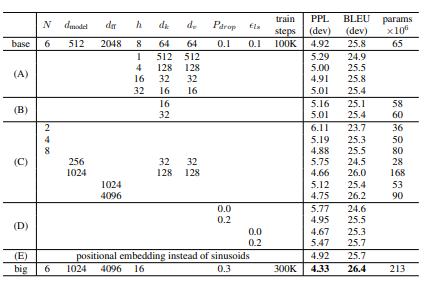

In [ ]:
arch_args = Namespace(
  encoder_embed_dim = 1024,
  encoder_ffn_embed_dim = 4096,
  encoder_layers = 6,
  decoder_embed_dim = 1024,
  decoder_ffn_embed_dim = 4096,
  decoder_layers = 6,
  share_decoder_input_output_embed = True,
  dropout = 0.3,
)

def add_transformer_args(args):
  args.encoder_attention_heads = 16
  args.encoder_normalize_before = True

  args.decoder_attention_heads = 16
  args.decoder_normalize_before = True

  args.activation_fn = "relu"
  args.max_source_positions = 1024
  args.max_target_positions = 1024

  from fairseq.models.transformer import base_architecture
  base_architecture(arch_args)
  
add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
  wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-08-04 09:09:45 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featur

**Label Smooth CrossEntropy Criterion**

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
  def __init__(self, smoothing, ignore_index = None, reduce = True):
    super().__init__()
    self.smoothing = smoothing
    self.ignore_index = ignore_index
    self.reduce = reduce
  def forward(self, lprobs, target):
    if target.dim() == lprobs.dim() - 1:
      target = target.unsqueeze(-1)
    #Negative log likelihood, 當目標是one-hot時的crossentropy loss
    nll_loss = -lprobs.gather(dim = -1, index = target)
    #將一部分正確答案的機率分配給其他label 所以當計算crossentropy時等於把所有label的log prob加起來
    smooth_loss = -lprobs.sum(dim = -1, keepdim = True)
    if self.ignore_index is not None:
      pad_mask = target.eq(self.ignore_index)
      nll_loss.masked_fill_(pad_mask, 0.0)
      smooth_loss.masked_fill_(pad_mask, 0.0)
    else:
      nll_loss = nll_loss.squeeze(-1)
      smooth_loss = smooth_loss.squeeze(-1)
    if self.reduce:
      nll_loss = nll_loss.sum()
      smooth_loss = smooth_loss.sum()
    eps_i = self.smoothing / lprobs.size(-1)
    loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
    return loss

criterion = LabelSmoothedCrossEntropyCriterion(smoothing = 0.1, ignore_index = task.target_dictionary.pad())

**Optimizer**

In [ ]:
class NoamOpt:
  "Optim wrapper that implements rate."
  def __init__(self, model_size, factor, warmup, optimizer):
    self.optimizer = optimizer
    self._step = 0
    self.warmup = warmup
    self.factor = factor
    self.model_size = model_size
    self._rate = 0
    
  @property
  def param_groups(self):
    return self.optimizer.param_groups
        
  def multiply_grads(self, c):
    """Multiplies grads by a constant *c*."""                
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is not None:
          p.grad.data.mul_(c)
        
  def step(self):
    "Update parameters and rate"
    self._step += 1
    rate = self.rate()
    for p in self.param_groups:
      p['lr'] = rate
    self._rate = rate
    self.optimizer.step()
        
  def rate(self, step = None):
    "Implement `lrate` above"
    if step is None:
      step = self._step
    return 0 if not step else self.factor * \
        (self.model_size ** (-0.5) *
        min(step ** (-0.5), step * self.warmup ** (-1.5)))

**排程視覺化**

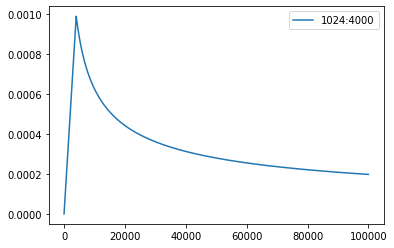

In [ ]:
optimizer = NoamOpt(
  model_size=arch_args.encoder_embed_dim, 
  factor=config.lr_factor, 
  warmup=config.lr_warmup, 
  optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

**Training**

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps = 1):
  itr = epoch_itr.next_epoch_itr(shuffle = True)
  itr = iterators.GroupedIterator(itr, accum_steps) #梯度累積

  stats = {"loss": []}
  scaler = GradScaler() #混和精度訓練

  model.train()
  progress = tqdm.tqdm(itr, desc = f"train epoch {epoch_itr.epoch}", leave = False)
  for samples in progress:
    model.zero_grad()
    accum_loss = 0
    sample_size = 0
    
    #梯度累積
    for i, sample in enumerate(samples):
      if i == 1:
        torch.cuda.empty_cache()
      sample = utils.move_to_cuda(sample, device = device)
      target = sample["target"]
      sample_size_i = sample["ntokens"]
      sample_size += sample_size_i

      #混和精度訓練
      with autocast():
        net_output = model.forward(**sample["net_input"])
        lprobs = F.log_softmax(net_output[0], -1)
        loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))

        #logging
        accum_loss += loss.item()
        #back-prop
        scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    optimizer.multiply_grads(1 / (sample_size or 1.0))
    gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) #梯度裁減, 避免梯度爆炸

    scaler.step(optimizer)
    scaler.update()

    loss_print = accum_loss / sample_size
    stats["loss"].append(loss_print)
    progress.set_postfix(loss = loss_print)
    if config.use_wandb:
      wandb.log({
          "train/loss": loss_print,
          "train/grad_norm": gnorm.item(),
          "train/lr": optimizer.rate(),
          "train/sample_size": sample_size,
      })
  loss_print = np.mean(stats["loss"])
  logger.info(f"training loss: {loss_print:.4f}")
  return stats

**Validation and Inference**

In [ ]:
sequence_generator = task.build_generator([model], config)
def decode(toks, dictionary):
  s = dictionary.string(
    toks.int().cpu(),
    config.post_process,
  )
def inference_step(sample, model):
  gen_out = sequence_generator.generate([model], sample)
  srcs = []
  hyps = []
  refs = []
  for i in range(len(gen_out)):
    srcs.append(decode(
      utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()),
      task.source_dictionary,
    ))
    hyps.append(decode(
      gen_out[i][0]["token"],
      task.target_dictionary,
    ))
    refs.append(decode(
      utils.strip_pad(sample["target"][i], task.target_dictionary.pad()),
      task.target_dictionary,
    ))
  return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb = True):
  logger.info('begin validation')
  itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle = False)

  stats = {"loss": [], "bleu": 0, "srcs": [], "hyps": [], "refs": []}
  srcs = []
  hyps = []
  refs = []

  model.eval()
  progress = tqdm.tqdm(itr, desc = f"validation", leave = False)
  with torch.no_grad():
    for i, sample in enumerate(progress):
      #validation loss
      sample = utils.move_to_cuda(sample, device = device)
      net_output = model.forward(**sample["net_input"])

      lprobs = F.log_softmax(net_output[0], 1)
      target = sample["target"]
      sample_size = sample["ntokens"]
      loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
      progress.set_postfix(valid_loss = loss.item())
      stats["loss"].append(loss)

      s, h, r = inference_step(sample, model)
      srcs.extend(s)
      hyps.extend(h)
      refs.extend(r)
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacreble.corpus_bleu(hyps, [refs], tokenize = tok)
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs

    if config.use_wandb and log_to_wandb:
      wandb.log({
        "valid/loss": stats["loss"],
        "valid/bleu": stats["bleu"].score,
      }, commit = False)
    showid = np.random.randint(len(hyps))
    logger.info("example source:" + srcs[showid])
    logger.info("example hypothesis:" + hyps[showid])
    logger.info("example reference:" + refs[showid])

    #show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

**save and load parameter of model**

In [ ]:
def validation_and_save(model, task, criterion, optimizer, epoch, save = True):
  stats = validate(model, task, criterion)
  bleu = stats['bleu']
  loss = stats['loss']
  if save:
    savedir = Path(config.savedir).absolute()
    savedir.mkdir(parents = True, exist_ok = True)

    check = {
      "model": model.state_dict(),
      "stats": {"bleu": bleu.score, "loss": loss},
      "optim": {"step": optimizer._step}
    }
    torch.save(check, savedir/f"checkpoint{epoch}.pt")
    shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
    logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")

    #save epoch samples
    with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
      for s, h in zip(stats["srcs"], stats["hyps"]):
        f.write(f"{s}\t{h}\n")
    score = bleu.score
    # get best valid bleu    
    if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
      validate_and_save.best_bleu = bleu.score
      torch.save(check, savedir/f"checkpoint_best.pt")
            
    del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
    if del_file.exists():
      del_file.unlink()
    
  return stats

def try_load_checkpoint(model, optimizer=None, name=None):
  name = name if name else "checkpoint_last.pt"
  checkpath = Path(config.savedir)/name
  if checkpath.exists():
    check = torch.load(checkpath)
    model.load_state_dict(check["model"])
    stats = check["stats"]
    step = "unknown"
    if optimizer != None:
      optimizer._step = step = check["optim"]["step"]
    logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
  else:
    logger.info(f"no checkpoints found at {checkpath}!")

**train loop**

In [ ]:
!nvidia-smi

Wed Aug  4 09:12:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   7935MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = model.to(device = device)
criterion = criterion.to(device = device)

**make prediction**

In [ ]:
def generate_prediction(model, task, split = "test", outfile = "./prediction.txt"):
  task.load_dataset(split=split, epoch=1)
  itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
  idxs = []
  hyps = []

  model.eval()
  progress = tqdm.tqdm(itr, desc=f"prediction")
  with torch.no_grad():
    for i, sample in enumerate(progress):
      # validation loss
      sample = utils.move_to_cuda(sample, device=device)

      # 進行推論
      s, h, r = inference_step(sample, model)
      # print(sample)
      # print(h)
      hyps.extend(h)
      idxs.extend(list(sample['id']))
            
  # 根據 preprocess 時的順序排列
  hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
  with open(outfile, "w") as f:
    for h in hyps:
      f.write(h+"\n")

**Back-translation**

In [ ]:
config = Namespace(
  datadir = "./DATA/data-bin/ted2020",
  savedir = "./checkpoints/rnn_back",
  source_lang = "zh",
  target_lang = "en",
    
  # cpu threads when fetching & processing data.
  num_workers=2,  
  # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
  max_tokens=8192,
  accum_steps=2,
    
  # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
  lr_factor=2.,
  lr_warmup=4000,
    
  # clipping gradient norm helps alleviate gradient exploding
  clip_norm=1.0,
    
  # maximum epochs for training
  max_epoch=40,
  start_epoch=1,
    
  # beam size for beam search
  beam=5, 
  # generate sequences of maximum length ax + b, where x is the source length
  max_len_a=1.2, 
  max_len_b=10,
  # when decoding, post process sentence by removing sentencepiece symbols.
  post_process = "sentencepiece",
    
  # checkpoints
  keep_last_epochs=5,
  resume=None, # if resume from checkpoint name (under config.savedir)
    
  # logging
  use_wandb=False,
)

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
  data=config.datadir,
  source_lang=config.source_lang,
  target_lang=config.target_lang,
  train_subset="train",
  required_seq_len_multiple=8,
  dataset_impl="mmap",
  upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-08-04 09:12:10 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-08-04 09:12:10 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-08-04 09:12:11 | INFO | hw5.seq2seq | loading data for epoch 1
2021-08-04 09:12:11 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-08-04 09:12:11 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-08-04 09:12:11 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-08-04 09:12:11 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-08-04 09:12:11 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-08-04 09:12:11 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
  "Source: " + \
  task.source_dictionary.string(
    sample['source'],
    config.post_process,
  )
)
pprint.pprint(
  "Target: " + \
  task.target_dictionary.string(
    sample['target'],
    config.post_process,
  )
)

{'id': 1,
 'source': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2]),
 'target': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


In [ ]:
logging.basicConfig(
  format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
  datefmt="%Y-%m-%d %H:%M:%S",
  level="INFO", # "DEBUG" "WARNING" "ERROR"
  stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
  import wandb
  wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-08-04 09:12:19 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featur

In [ ]:
sequence_generator = task.build_generator([model], config)
model = model.to(device = device)
criterion = criterion.to(device = device)
demo_epoch_obj = load_data_iterator(task, "valid", epoch = 1, max_tokens = 20, num_workers = 1, cached = False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle = True)
sample = next(demo_iter)
sample

2021-08-04 09:12:19 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 527, 1633, 76, 2861, 2415, 2890, 210, 880, 636]


{'id': tensor([963]),
 'net_input': {'prev_output_tokens': tensor([[   2,  554,   36,   38,    7,   55,   24,  155,    4,  278,  407, 1362,
             26, 1011,   25,  153, 2055,    7,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([17]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,    1,    5,  971, 1132,  373,  160,
            516,  315,  433,   33,    5, 3673, 2044,  339,  230,  102,  976,    2]])},
 'nsentences': 1,
 'ntokens': 18,
 'target': tensor([[ 554,   36,   38,    7,   55,   24,  155,    4,  278,  407, 1362,   26,
          1011,   25,  153, 2055,    7,    2,    1,    1,    1,    1,    1,    1]])}

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
  "num. model params: {:,} (num. trained: {:,})".format(
    sum(p.numel() for p in model.parameters()),
    sum(p.numel() for p in model.parameters() if p.requires_grad),
  )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-08-04 09:12:19 | INFO | hw5.seq2seq | task: TranslationTask
2021-08-04 09:12:19 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-08-04 09:12:19 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-08-04 09:12:19 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-08-04 09:12:19 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-08-04 09:12:19 | INFO | hw5.seq2seq | num. model params: 192,745,472 (num. trained: 192,745,472)
2021-08-04 09:12:19 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


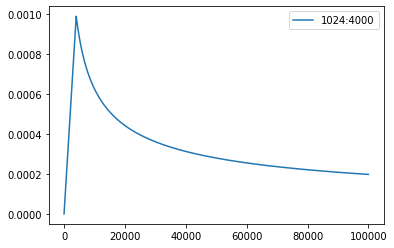

In [ ]:
optimizer = NoamOpt(
  model_size=arch_args.encoder_embed_dim, 
  factor=config.lr_factor, 
  warmup=config.lr_warmup, 
  optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
  # train for one epoch
  train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
  stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
  logger.info("end of epoch {}".format(epoch_itr.epoch))    
  epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-08-04 09:13:28 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn_back/checkpoint_last.pt!


RuntimeError: ignored

In [ ]:
mono_dataset_name = 'mono'
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents =True, exist_ok = True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
  'ted_zh_corpus.deduped.gz',
)
for u, f in zip(urls, file_names):
  path = mono_prefix/f
  if not path.exists():
    if 'mega' in u:
      !megadl{u} --path {path}
    else:
      !wget {u} -O {path}
  else:
    print(f'{f} is exist, skip downloading')
  if path.suffix == ".tgz":
    !tar -xvf {path} -C {prefix}
  elif path.suffix == ".zip":
    !unzip -o {path} -d {prefix}
  elif path.suffix == ".gz":
    !gzip -fkd {path}

In [ ]:
!pip install jieba
import jieba
import random
random.seed(901027)

def rand_delete(line, p=0.1):
  remove = []
  for i in range(len(line) - 1):
    if random.randint(0, 100) < prob*100:
      remove.append(line[i])

  for x in remove:
    line.remove(x)
    
  return ''.join(line)

def rand_switch(line, n_times):
  idx = range(len(line) - 1)
  for i in range(n_times):
    i1, i2 = random.sample(idx, 2)
    line[i1], line[i2] = line[i2], line[i1]
    
  return ''.join(line)

with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as f_read:
  with open(f'{mono_prefix}/ted_zh_corpus.deduped1', 'w') as f_write:
    line = f_read.readline()
    line = jieba.cut(line, cut_all = False)
    line = " ".join(line)
    line = line.split(" ")
    num = random.randint(0,1)
    if num == 0:
      line = rand_delete(line, p=0.1)
    else:
      times = (len(line) // 10) + 1
      line = rand_switch(line, times)
    f_write.write(line)

**Clean Dataset**

In [ ]:
def mono_clean_corpus(prefix, max_len=1000, min_len=1):
  if Path(f'{prefix}.clean').exists():
    print(f'{prefix}.clean exists. skipping clean.')
    return
  with open(f'{prefix}', 'r') as l1_in_f:
    with open(f'{prefix}.clean', 'w') as l1_out_f:
      for s1 in l1_in_f:
        s1 = s1.strip()
        s1 = clean_s(s1, "zh")
        s1_len = len_s(s1, "zh")
        if min_len > 0: # remove short sentence
          if s1_len < min_len:
            continue
        if max_len > 0: # remove long sentence
          if s1_len > max_len:
            continue
        print(s1, file=l1_out_f)
mono_clean_corpus(f'{mono_prefix}/ted_zh_corpus.deduped')
mono_clean_corpus(f'{mono_prefix}/ted_zh_corpus.deduped1')

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (mono_prefix/f'spm{vocab_size}.model').exists():
  print(f'{mono_prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
  spm.SentencePieceTrainer.train(
    input=f'{mono_prefix}/ted_zh_corpus.deduped.clean',
    model_prefix=mono_prefix/f'spm{vocab_size}',
    vocab_size=vocab_size,
    character_coverage=1,
    model_type='unigram', # 'bpe' works as well
    input_sentence_size=1e6,
    shuffle_input_sentence=True,
    normalization_rule_name='nmt_nfkc_cf',
  )

spm_model = spm.SentencePieceProcessor(model_file=str(mono_prefix/f'spm{vocab_size}.model'))

out_path = mono_prefix/f'mono.tok.zh'
if out_path.exists():
  print(f"{out_path} exists. skipping spm_encode.")
else:
  with open(mono_prefix/f'mono.tok.zh', 'w') as out_f:
    with open(mono_prefix/f'ted_zh_corpus.deduped.clean', 'r') as in_f:
      for line in in_f:
        line = line.strip()
        tok = spm_model.encode(line, out_type=str)
        print(' '.join(tok), file=out_f)

out_path = mono_prefix/f'mono.tok1.zh'
if out_path.exists():
  print(f"{out_path} exists. skipping spm_encode.")
else:
  with open(mono_prefix/f'mono.tok.zh', 'w') as out_f:
    with open(mono_prefix/f'ted_zh_corpus.deduped.clean', 'r') as in_f:
      for line in in_f:
        line = line.strip()
        tok = spm_model.encode(line, out_type=str)
        print(' '.join(tok), file=out_f)

In [ ]:
!head {mono_prefix}/ted_zh_corpus.deduped.clean -n 5
!head {mono_prefix}/mono.tok.zh -n 5

!head {mono_prefix}/ted_zh_corpus.deduped1.clean -n 5
!head {mono_prefix}/mono.tok1.zh -n 5

**Binarize**

In [ ]:
en_path = './DATA/rawdata/mono/mono.tok.en'
zh_path = './DATA/rawdata/mono/mono.tok.zh'
en_path1 = './DATA/rawdata/mono/mono.tok1.en'
zh_path1 = './DATA/rawdata/mono/mono.tok1.zh'
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1
length = file_len(zh_path)
with open(en_path, "w") as f:
  for i in tqdm.tqdm(range(length)):
    f.write("▁ 。\n")

length = file_len(zh_path1)
with open(en_path1, "w") as f:
  for i in tqdm.tqdm(range(length)):
    f.write("▁ 。\n")
# input("QQQQQ")

binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
  print(binpath, "exists, will not overwrite!")
else:
  !python -m fairseq_cli.preprocess\
    --source-lang 'zh'\
    --target-lang 'en'\
    --trainpref {monopref}\
    --destdir {binpath}\
    --srcdict {src_dict_file}\
    --tgtdict {tgt_dict_file}\
    --workers 2

**Generate Back-translation data**

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
# averaging a few checkpoints can have a similar effect to ensemble
try_load_checkpoint(model, name="checkpoint_best.pt")

generate_prediction(model, task, split="mono", outfile="./back_pred.txt" )
print("Finished back predicting!!!")

**Generate new dataset**

In [ ]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))

out_path = mono_prefix/f'mono.tok.en'
with open(mono_prefix/f'mono.tok.en', 'w') as out_f:
  with open('./back_pred.txt', 'r') as in_f:
    for line in in_f:
      line = line.strip()
      tok = spm_model.encode(line, out_type=str)
      print(' '.join(tok), file=out_f)
# input()

# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = "./DATA/rawdata/mono/mono.tok" # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
!python -m fairseq_cli.preprocess\
  --source-lang 'zh'\
  --target-lang 'en'\
  --trainpref {monopref}\
  --destdir {binpath}\
  --srcdict {src_dict_file}\
    --tgtdict {tgt_dict_file}\
  --workers 2

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

**re-train**

In [ ]:
config = Namespace(
  datadir = "./DATA/data-bin/ted2020_with_mono",
  savedir = "./checkpoints/rnn_bt",
  source_lang = "en",
  target_lang = "zh",
    
  # cpu threads when fetching & processing data.
  num_workers=2,  
  # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
  max_tokens=8192,
  accum_steps=2,
    
  # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
  lr_factor=2.,
  lr_warmup=4000,
    
  # clipping gradient norm helps alleviate gradient exploding
  clip_norm=1.0,
    
  # maximum epochs for training
  max_epoch=150,
  start_epoch=1,
  early_stop=5,
    
  # beam size for beam search
  beam=5, 
  # generate sequences of maximum length ax + b, where x is the source length
  max_len_a=1.2, 
  max_len_b=10,
  # when decoding, post process sentence by removing sentencepiece symbols.
  post_process = "sentencepiece",
    
  # checkpoints
  keep_last_epochs=5,
  resume=None, # if resume from checkpoint name (under config.savedir)
    
  # logging
  use_wandb=False,
)

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
  data=config.datadir,
  source_lang=config.source_lang,
  target_lang=config.target_lang,
  train_subset="train",
  required_seq_len_multiple=8,
  dataset_impl="mmap",
  upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
  "Source: " + \
  task.source_dictionary.string(
    sample['source'],
    config.post_process,
  )
)
pprint.pprint(
  "Target: " + \
  task.target_dictionary.string(
    sample['target'],
    config.post_process,
  )
)

In [ ]:
logging.basicConfig(
  format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
  datefmt="%Y-%m-%d %H:%M:%S",
  level="INFO", # "DEBUG" "WARNING" "ERROR"
  stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
  import wandb
  wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [ ]:
sequence_generator = task.build_generator([model], config)
model = model.to(device = device)
criterion = criterion.to(device = device)
demo_epoch_obj = load_data_iterator(task, "valid", epoch = 1, max_tokens = 20, num_workers = 1, cached = False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle = True)
sample = next(demo_iter)
sample

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
  "num. model params: {:,} (num. trained: {:,})".format(
    sum(p.numel() for p in model.parameters()),
    sum(p.numel() for p in model.parameters() if p.requires_grad),
  )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

In [ ]:
optimizer = NoamOpt(
  model_size=arch_args.encoder_embed_dim, 
  factor=config.lr_factor, 
  warmup=config.lr_warmup, 
  optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])

In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
score = 0
best_score = 0
cur = 0
while epoch_itr.next_epoch_idx <= config.max_epoch:
  # train for one epoch
  if score > best_score:
    cur += 1
  if cur > config.early_stop:
    break
  train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
  stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
  logger.info("end of epoch {}".format(epoch_itr.epoch))    
  epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)
  if score > best_score:
    best_score = score
    cur = 0

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt
try_load_checkpoint(model, name="checkpoint_best.pt")

generate_prediction(model, task)